# Coursera Capstone - Battle of the Neighbourhoods (Week 2)

<h2>Where to open a Greek restaurant in New York?<h2>

<h3>Introduction<h3><br>

<h4>Family friends are looking to emigrate from Greece to open a restaurant in New York; so what are the current trends and locations of existing Greek restaurants and where may be a suitable location to establish a new venue?<h4><br>
    <br>

<h4> Background<H4><br>
    
As part of this group-owned enterprise there are currently two highly popular restaurants operating in the major cities Athens and Thessaloniki. The menu is a blend of upmarket modern and traditional Greek cuisine with inspiration from experienced chefs in their employ. The group would like to selectively expand overseas and are confident that through good food and smart business practices, the restaurant can succeed.<br>
    
The group has chosen New York as a location to conduct research before committing. The city boasts a population of over 8 million people (https://en.wikipedia.org/wiki/New_York_City) with one of the most multi cultural cities on earth. Although those identifying with Greek heritage in New York City is small with slightly less than 1%   https://unreachednewyork.com/wp-content/uploads/2012/11/Greek-Profile-Final.pdf ) there is a strong presence in the neighbourhood of Astoria. This being the case, the reliance on those with Greek heritage would not be the customer base. The restaurant would appeal to 3 to 4-star dining as part of the current operating model.<br>
    
In addition to expanding the business internationally, our family friends have lead this investigation as they have  children & grandchildren in New York and would like to be permanently closer to them whilst managing the American branch and potential future expansions.
<h4><br>
<h4>Source Data<h4><br>

•	New York city locations neighborhoods and boroughs, with coordinated will be obtained from the data source: https://cocl.us/new_york_dataset<br>
•	In order to gather data for existing Greek restaurants, the location platform FourSquare ( https://foursquare.com/ ) will be accessed and matched with our dataset.<br>

Processing<br>

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe focussing on Greek restaurants in the 5 boroughs.
• The location platform FourSquare is used to locate and filter Greek restaurant venues. The ratings, tips, and likes by Foursquare users are matched and added to the dataframe.
• Data is filtered to determine venue trends and how different neighbourhoods compare.

The final summary and recommendations will be made once the data has been processed.

In [1]:
# First - import the relevant pandas libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [13]:
#Foursquare details and version - 
CLIENT_ID =  '*****'  #Foursquare Client ID
CLIENT_SECRET = '****' #Foursquare Client Secret
VERSION = '20210115' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: 43UJERGH03H5F4NVBISC3NYNUFG1D4HU3B1OF2CPQV0FMF5Z
CLIENT_SECRET:OTA2ERNFN41JCNXBCRQU2QWEFWPSPTBOTLFA3EGOGDZ5LGMR


In [31]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=1000
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [32]:
#ny_data = ny_df1
ny_df1 = get_new_york_data()
ny_df1.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_df1.shape

(306, 4)

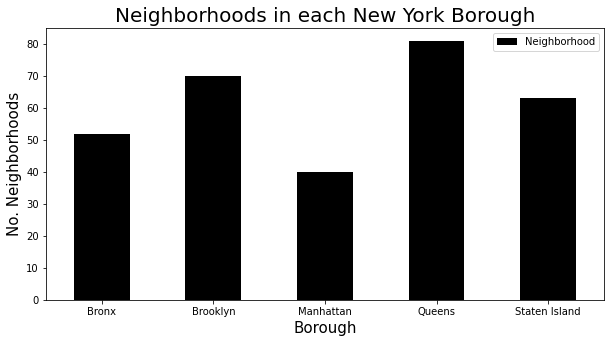

In [6]:
clr = "blue"
ny_df1.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color="black")
plt.title('Neighborhoods in each New York Borough', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()


In [7]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
#IF this comes up with an error for 'groups' the Foursquare API calls may have been exceeded for the day
column_names=['Borough', 'Neighborhood', 'ID','Name']
greek_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_df1.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    greek_restaurants=venues[venues['Category']=='Greek Restaurant']   
    print('(',count,'/',len(ny_df1),')','Greek Restaurants in '+Neighborhood+', '+Borough+':'+str(len(greek_restaurants)))
    print(row)
    for restaurant_detail in greek_restaurants.values.tolist():
        id, name , category=restaurant_detail
        greek_rest_ny = greek_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Greek Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Greek Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Greek Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Greek Restaurants in Fieldston, Bronx:1
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Greek Restaurants in Riverdale, Bronx:1
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Greek Restaurants in Kingsbridge, Bronx:1
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Greek Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Greek Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Greek Restaurants in Norwood, Bronx:0
['Bronx', 'Norwood',

( 69 / 306 ) Greek Restaurants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Greek Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Greek Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Greek Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Greek Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Greek Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Greek Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]
( 76 / 306 ) Greek Restaurants in Flatlands, Brooklyn:0
['Brooklyn', 'Flatlands', 40.630446043757466, -73.92911302644674]
( 77 

( 133 / 306 ) Greek Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Greek Restaurants in Howard Beach, Queens:1
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Greek Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Greek Restaurants in Forest Hills, Queens:1
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Greek Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Greek Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Greek Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Greek Restaurants in Long Island City, Queens:0
['Queens', 'Long Island City', 40.75021734610528, -73.93920223915505]
( 141 / 306 ) Greek Restauran

( 200 / 306 ) Greek Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Greek Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Greek Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Greek Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Greek Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Greek Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Greek Restaurants in Port Richmond, Staten Island:0
['Staten Island', 'Port Richmond', 40.63366930554365, -74.12943426797008]
( 207 / 306 ) Greek Restaurants in Mariner's Harbor, Sta

( 262 / 306 ) Greek Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Greek Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Greek Restaurants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Greek Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Greek Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Greek Restaurants in Astoria Heights, Queens:2
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
( 268 / 306 ) Greek Restaurants in Claremont Village, Bronx:0
['Bronx', 'Claremont Village', 40.83142834161548, -73.90119903387667]
( 269 / 306 ) Greek Restaurants in Concourse Village, Bronx:0
['Bronx', 'Concourse Village', 40.824780490842905, -73.915846527590

In [8]:
#greek_rest_ny.to_csv('greek_rest_ny_csv.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
greek_rest_ny.to_csv('greek_rest_ny_csv.csv')

In [3]:
greek_only_ny = pd.read_csv('greek_rest_ny_csv.csv')
greek_only_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
67,67,Manhattan,Turtle Bay,558e0da4498ee9c7ccf46a5c,Pathos Cafe
68,68,Manhattan,Tudor City,54b6a080498eb25858020b88,EONS Greek Food for Life
69,69,Manhattan,Stuyvesant Town,52269b14498e6a221ec8e301,Taverna Kyclades
70,70,Queens,Queensbridge,56983e51498e8b2767ade046,3 Greeks Grill
71,71,Queens,Queensbridge,5a3b265d8c812a3ed8ee6985,NISI


In [4]:
greek_only_ny.shape

(72, 5)

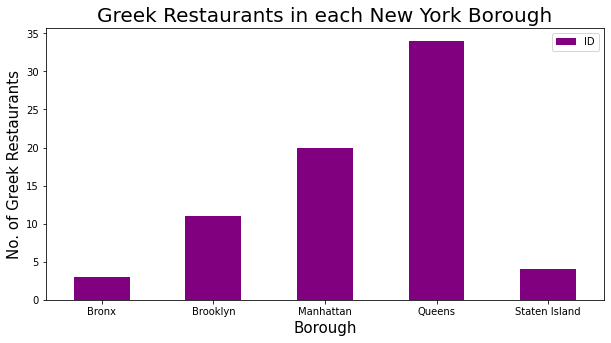

In [11]:
greek_only_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color="purple")
plt.title('Greek Restaurants in each New York Borough', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Greek Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

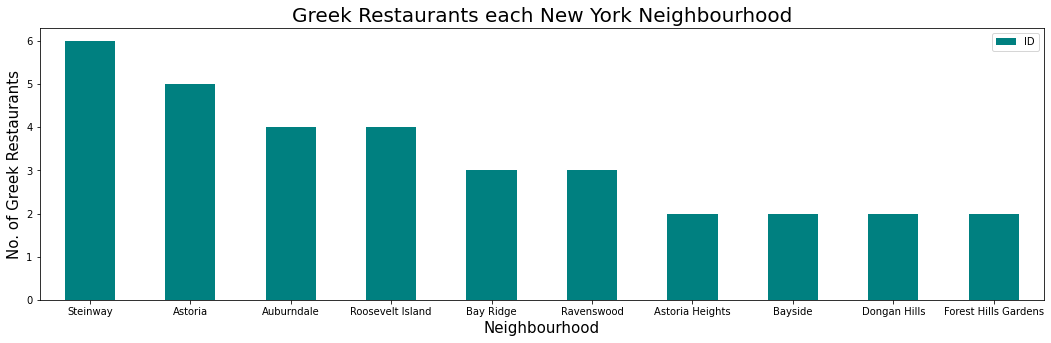

In [13]:
TopNeigh = 10 # top number for graphing all the same past 6
greek_only_ny.groupby('Neighborhood')['ID'].count().nlargest(TopNeigh).plot.bar(figsize=(18,5), color="teal")
plt.title('Greek Restaurants each New York Neighbourhood', fontsize = 20)
plt.xlabel('Neighbourhood', fontsize = 15)
plt.ylabel('No. of Greek Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [5]:
#Remove unnamed column
greek_only_ny.drop('Unnamed: 0', axis=1, inplace=True)
greek_only_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Fieldston,4bc39d1d2a89ef3bdf49f588,Greek Express
1,Bronx,Riverdale,4bc39d1d2a89ef3bdf49f588,Greek Express
2,Bronx,Kingsbridge,4bc39d1d2a89ef3bdf49f588,Greek Express
3,Brooklyn,Bay Ridge,4bbce66da0a0c9b6b9f41a0f,Elia Restaurant
4,Brooklyn,Bay Ridge,58fa85be98fbfc397bafe21f,Blue Door Souvlakia


In [6]:
# Steinway has the most Greek restaurants
greek_only_ny[greek_only_ny['Neighborhood']=='Steinway']

,Borough,Neighborhood,ID,Name
45,Queens,Steinway,4b491ca9f964a520586626e3,Loukoumi Taverna
46,Queens,Steinway,4a8e20edf964a520131220e3,Taverna Kyclades
47,Queens,Steinway,48a7dcf0f964a520a0511fe3,Telly's Taverna
48,Queens,Steinway,4a9b2269f964a520863420e3,Stamatis
49,Queens,Steinway,4a5a425df964a52003ba1fe3,Zorba's Souvlaki Plus
50,Queens,Steinway,561a965b498e99e2d7512565,Dionysos Restaurant


In [15]:
#make sure source columns in Line 5 match otherwise will come up with 'too many rows to unpack (expected 4)'
# If Venue error means Foursquare quota exceeded. Already have dataframe - start from Line 9 to import the csv
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
greek_rest_details_ny=pd.DataFrame(columns=column_names)
count=1
for row in greek_only_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(greek_only_ny),')','processed')
    greek_rest_details_ny = greek_rest_details_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
greek_rest_details_ny.head()
#13/01/21 up to here. 

{'meta': {'code': 200, 'requestId': '60017ff272d6e6460f20bd57'}, 'response': {'venue': {'id': '4bc39d1d2a89ef3bdf49f588', 'name': 'Greek Express', 'contact': {'phone': '7186014976', 'formattedPhone': '(718) 601-4976'}, 'location': {'address': '3733 Riverdale Ave', 'crossStreet': 'W 238th St', 'lat': 40.88749950271757, 'lng': -73.90726184172892, 'labeledLatLngs': [{'label': 'display', 'lat': 40.88749950271757, 'lng': -73.90726184172892}, {'label': 'entrance', 'lat': 40.887528, 'lng': -73.907425}], 'postalCode': '10463', 'cc': 'US', 'neighborhood': 'Riverdale', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3733 Riverdale Ave (W 238th St)', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/greek-express/4bc39d1d2a89ef3bdf49f588', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/foo

{'meta': {'code': 200, 'requestId': '60017ff3a59dd21afacf68e0'}, 'response': {'venue': {'id': '4bc39d1d2a89ef3bdf49f588', 'name': 'Greek Express', 'contact': {'phone': '7186014976', 'formattedPhone': '(718) 601-4976'}, 'location': {'address': '3733 Riverdale Ave', 'crossStreet': 'W 238th St', 'lat': 40.88749950271757, 'lng': -73.90726184172892, 'labeledLatLngs': [{'label': 'display', 'lat': 40.88749950271757, 'lng': -73.90726184172892}, {'label': 'entrance', 'lat': 40.887528, 'lng': -73.907425}], 'postalCode': '10463', 'cc': 'US', 'neighborhood': 'Riverdale', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3733 Riverdale Ave (W 238th St)', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/greek-express/4bc39d1d2a89ef3bdf49f588', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/foo

{'meta': {'code': 200, 'requestId': '60017ff58840934787508a27'}, 'response': {'venue': {'id': '58fa85be98fbfc397bafe21f', 'name': 'Blue Door Souvlakia', 'contact': {'phone': '7186808600', 'formattedPhone': '(718) 680-8600'}, 'location': {'address': '8413 3rd Ave', 'lat': 40.624567, 'lng': -74.030311, 'labeledLatLngs': [{'label': 'display', 'lat': 40.624567, 'lng': -74.030311}, {'label': 'entrance', 'lat': 40.624609, 'lng': -74.030439}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8413 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/blue-door-souvlakia/58fa85be98fbfc397bafe21f', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 6}, 'url

{'meta': {'code': 200, 'requestId': '60017ff83253c51e9abf1f73'}, 'response': {'venue': {'id': '4bdc6a0d3904a593f7104e9e', 'name': 'Yiasou', 'contact': {'phone': '7183226064', 'formattedPhone': '(718) 322-6064', 'twitter': 'yiasou2003'}, 'location': {'address': '2003 Emmons Ave', 'crossStreet': 'Ocean', 'lat': 40.58387183725412, 'lng': -73.94825188818548, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58387183725412, 'lng': -73.94825188818548}, {'label': 'entrance', 'lat': 40.583849, 'lng': -73.948146}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2003 Emmons Ave (Ocean)', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yiasou/4bdc6a0d3904a593f7104e9e', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '60017ff9e53c096fdfa7335d'}, 'response': {'venue': {'id': '56c33c50cd1020ede4b92a2e', 'name': 'To Spiti', 'contact': {'phone': '9177548318', 'formattedPhone': '(917) 754-8318', 'facebook': '222691454737653', 'facebookUsername': 'tospitinyc', 'facebookName': 'To Spiti'}, 'location': {'address': '160 Havemeyer St', 'crossStreet': 'btwn S 2nd St and S 3rd St', 'lat': 40.71145222603289, 'lng': -73.95763719293313, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71145222603289, 'lng': -73.95763719293313}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['160 Havemeyer St (btwn S 2nd St and S 3rd St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/to-spiti/56c33c50cd1020ede4b92a2e', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4s

{'meta': {'code': 200, 'requestId': '60017ff9f77af50c9ba4947d'}, 'response': {'venue': {'id': '511316aee4b036fd387843fb', 'name': 'Avlee Greek Kitchen', 'contact': {'phone': '7188555125', 'formattedPhone': '(718) 855-5125', 'twitter': 'avleekitchen'}, 'location': {'address': '349 Smith St', 'lat': 40.679975303933674, 'lng': -73.99498828355762, 'labeledLatLngs': [{'label': 'display', 'lat': 40.679975303933674, 'lng': -73.99498828355762}, {'label': 'entrance', 'lat': 40.679919, 'lng': -73.994957}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['349 Smith St', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/avlee-greek-kitchen/511316aee4b036fd387843fb', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'prima

{'meta': {'code': 200, 'requestId': '60017ffa9e0a315fef8637de'}, 'response': {'venue': {'id': '511316aee4b036fd387843fb', 'name': 'Avlee Greek Kitchen', 'contact': {'phone': '7188555125', 'formattedPhone': '(718) 855-5125', 'twitter': 'avleekitchen'}, 'location': {'address': '349 Smith St', 'lat': 40.679975303933674, 'lng': -73.99498828355762, 'labeledLatLngs': [{'label': 'display', 'lat': 40.679975303933674, 'lng': -73.99498828355762}, {'label': 'entrance', 'lat': 40.679919, 'lng': -73.994957}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['349 Smith St', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/avlee-greek-kitchen/511316aee4b036fd387843fb', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'prima

{'meta': {'code': 200, 'requestId': '60017ffbac79113354d176f8'}, 'response': {'venue': {'id': '4bdc6a0d3904a593f7104e9e', 'name': 'Yiasou', 'contact': {'phone': '7183226064', 'formattedPhone': '(718) 322-6064', 'twitter': 'yiasou2003'}, 'location': {'address': '2003 Emmons Ave', 'crossStreet': 'Ocean', 'lat': 40.58387183725412, 'lng': -73.94825188818548, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58387183725412, 'lng': -73.94825188818548}, {'label': 'entrance', 'lat': 40.583849, 'lng': -73.948146}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2003 Emmons Ave (Ocean)', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yiasou/4bdc6a0d3904a593f7104e9e', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '60017ffcc754223a4e40e4b3'}, 'response': {'venue': {'id': '4bb7c65e53649c74ca4146fb', 'name': 'Plaka Taverna', 'contact': {'phone': '7186803056', 'formattedPhone': '(718) 680-3056'}, 'location': {'address': '406 86th St', 'crossStreet': '4th Avenue', 'lat': 40.62248624337034, 'lng': -74.02846542169956, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62248624337034, 'lng': -74.02846542169956}, {'label': 'entrance', 'lat': 40.622536, 'lng': -74.02824}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['406 86th St (4th Avenue)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/plaka-taverna/4bb7c65e53649c74ca4146fb', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '60017ffd9661b37fc4f7e71d'}, 'response': {'venue': {'id': '4bbce66da0a0c9b6b9f41a0f', 'name': 'Elia Restaurant', 'contact': {'phone': '7187489891', 'formattedPhone': '(718) 748-9891', 'twitter': 'eliarestaurant'}, 'location': {'address': '8611 3rd Ave', 'crossStreet': 'Near 86 street', 'lat': 40.62309044402409, 'lng': -74.03115569866006, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62309044402409, 'lng': -74.03115569866006}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8611 3rd Ave (Near 86 street)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/elia-restaurant/4bbce66da0a0c9b6b9f41a0f', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '60017ffe1c80e062c5b90410'}, 'response': {'venue': {'id': '4bb7c65e53649c74ca4146fb', 'name': 'Plaka Taverna', 'contact': {'phone': '7186803056', 'formattedPhone': '(718) 680-3056'}, 'location': {'address': '406 86th St', 'crossStreet': '4th Avenue', 'lat': 40.62248624337034, 'lng': -74.02846542169956, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62248624337034, 'lng': -74.02846542169956}, {'label': 'entrance', 'lat': 40.622536, 'lng': -74.02824}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['406 86th St (4th Avenue)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/plaka-taverna/4bb7c65e53649c74ca4146fb', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '60017ffe9fc7d574b235b9b3'}, 'response': {'venue': {'id': '5521c2ff498ebe2368634187', 'name': "Kiki's", 'contact': {'phone': '6468827052', 'formattedPhone': '(646) 882-7052', 'facebook': '739458446170956', 'facebookName': "Kiki's"}, 'location': {'address': '130 Division St', 'crossStreet': 'btwn Orchard & Ludlow St', 'lat': 40.714476082876864, 'lng': -73.99203609673215, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714476082876864, 'lng': -73.99203609673215}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Chinatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['130 Division St (btwn Orchard & Ludlow St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kikis/5521c2ff498ebe2368634187', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

{'meta': {'code': 200, 'requestId': '60017fffcde0a63d8aa0cd7e'}, 'response': {'venue': {'id': '4f0e53fde4b0129c73efceb4', 'name': 'Yefsi Estiatorio', 'contact': {'phone': '2125350293', 'formattedPhone': '(212) 535-0293', 'twitter': 'yefsiestiatorio'}, 'location': {'address': '1481 York Ave', 'crossStreet': 'at E 78th St', 'lat': 40.7710280933592, 'lng': -73.95084973263214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7710280933592, 'lng': -73.95084973263214}, {'label': 'entrance', 'lat': 40.770997, 'lng': -73.950926}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1481 York Ave (at E 78th St)', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yefsi-estiatorio/4f0e53fde4b0129c73efceb4', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '6001800072d6e6460f20e2bc'}, 'response': {'venue': {'id': '54f6ef74498ef551d4d3aadc', 'name': 'Greek Eats', 'contact': {'phone': '2128614976', 'formattedPhone': '(212) 861-4976', 'twitter': 'greek_eats', 'facebook': '966053710103646', 'facebookUsername': 'greekeatsnyc', 'facebookName': 'Greek Eats NYC'}, 'location': {'address': '1229 1st Ave', 'lat': 40.764407, 'lng': -73.95878689999999, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.764307, 'lng': -73.958751}, {'label': 'display', 'lat': 40.764407, 'lng': -73.95878689999999}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1229 1st Ave', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/greek-eats/54f6ef74498ef551d4d3aadc', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sq

{'meta': {'code': 200, 'requestId': '6001800172d6e6460f20e4ea'}, 'response': {'venue': {'id': '5a3b265d8c812a3ed8ee6985', 'name': 'NISI', 'contact': {'phone': '2127521517', 'formattedPhone': '(212) 752-1517'}, 'location': {'address': '549 Main St', 'lat': 40.76191465854082, 'lng': -73.94996590025112, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76191465854082, 'lng': -73.94996590025112}], 'postalCode': '10044', 'cc': 'US', 'neighborhood': 'Roosevelt Island', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['549 Main St', 'New York, NY 10044', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nisi/5a3b265d8c812a3ed8ee6985', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://www.nisikitc

{'meta': {'code': 200, 'requestId': '6001800272d6e6460f20e95f'}, 'response': {'venue': {'id': '54f6ef74498ef551d4d3aadc', 'name': 'Greek Eats', 'contact': {'phone': '2128614976', 'formattedPhone': '(212) 861-4976', 'twitter': 'greek_eats', 'facebook': '966053710103646', 'facebookUsername': 'greekeatsnyc', 'facebookName': 'Greek Eats NYC'}, 'location': {'address': '1229 1st Ave', 'lat': 40.764407, 'lng': -73.95878689999999, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.764307, 'lng': -73.958751}, {'label': 'display', 'lat': 40.764407, 'lng': -73.95878689999999}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1229 1st Ave', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/greek-eats/54f6ef74498ef551d4d3aadc', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sq

{'meta': {'code': 200, 'requestId': '6001800478a0a07d3b0937ac'}, 'response': {'venue': {'id': '4f0e53fde4b0129c73efceb4', 'name': 'Yefsi Estiatorio', 'contact': {'phone': '2125350293', 'formattedPhone': '(212) 535-0293', 'twitter': 'yefsiestiatorio'}, 'location': {'address': '1481 York Ave', 'crossStreet': 'at E 78th St', 'lat': 40.7710280933592, 'lng': -73.95084973263214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7710280933592, 'lng': -73.95084973263214}, {'label': 'entrance', 'lat': 40.770997, 'lng': -73.950926}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1481 York Ave (at E 78th St)', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yefsi-estiatorio/4f0e53fde4b0129c73efceb4', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '60018005d040043198bf8cdc'}, 'response': {'venue': {'id': '5bc19b6a249623002c0edee9', 'name': 'Eléa', 'contact': {'phone': '2123699800', 'formattedPhone': '(212) 369-9800', 'instagram': 'elea_nyc', 'facebook': '1363632107115290', 'facebookName': 'Elea'}, 'location': {'address': '217 W 85th St', 'crossStreet': '85th St & Broadway', 'lat': 40.78753120889783, 'lng': -73.97668142481366, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78753120889783, 'lng': -73.97668142481366}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['217 W 85th St (85th St & Broadway)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el%C3%A9a/5bc19b6a249623002c0edee9', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_'

{'meta': {'code': 200, 'requestId': '6001800611c51b2f0d37436b'}, 'response': {'venue': {'id': '4a9c75e1f964a520403720e3', 'name': 'The Greek Kitchen', 'contact': {'phone': '2125814300', 'formattedPhone': '(212) 581-4300', 'twitter': 'greekkitchennyc'}, 'location': {'address': '889 10th Ave', 'crossStreet': 'at W 58th St', 'lat': 40.76968955893778, 'lng': -73.98823816523908, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76968955893778, 'lng': -73.98823816523908}], 'postalCode': '10019', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['889 10th Ave (at W 58th St)', 'New York, NY 10019', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-greek-kitchen/4a9c75e1f964a520403720e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '6001800842b1531852f20410'}, 'response': {'venue': {'id': '52269b14498e6a221ec8e301', 'name': 'Taverna Kyclades', 'contact': {'phone': '2124320011', 'formattedPhone': '(212) 432-0011'}, 'location': {'address': '228 1st Ave', 'crossStreet': '13th and 14th St', 'lat': 40.731354, 'lng': -73.983021, 'labeledLatLngs': [{'label': 'display', 'lat': 40.731354, 'lng': -73.983021}, {'label': 'entrance', 'lat': 40.731064, 'lng': -73.982573}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['228 1st Ave (13th and 14th St)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taverna-kyclades/52269b14498e6a221ec8e301', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}, {'i

{'meta': {'code': 200, 'requestId': '60018008d3634d4b3ba246d9'}, 'response': {'venue': {'id': '4d86c784af642c0f4f8d0fb1', 'name': 'Souvlaki GR', 'contact': {'phone': '2127770116', 'formattedPhone': '(212) 777-0116', 'twitter': 'souvlakigr'}, 'location': {'address': '116 Stanton St', 'crossStreet': 'btwn Essex & Ludlow St.', 'lat': 40.721114, 'lng': -73.987174, 'labeledLatLngs': [{'label': 'display', 'lat': 40.721114, 'lng': -73.987174}, {'label': 'entrance', 'lat': 40.721116, 'lng': -73.98716}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['116 Stanton St (btwn Essex & Ludlow St.)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/souvlaki-gr/4d86c784af642c0f4f8d0fb1', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffi

{'meta': {'code': 200, 'requestId': '60018009dbed4b2397d22c5a'}, 'response': {'venue': {'id': '51b3c734498e2c9c744309e6', 'name': 'The Greek', 'contact': {'phone': '6464763941', 'formattedPhone': '(646) 476-3941', 'twitter': 'thegreektribeca', 'facebook': '478749048878815', 'facebookUsername': 'thegreektribeca', 'facebookName': 'The Greek Tribeca'}, 'location': {'address': '458 Greenwich St', 'crossStreet': 'btwn Watts St & Desbrosses St', 'lat': 40.72369353202312, 'lng': -74.00959789834022, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72369353202312, 'lng': -74.00959789834022}, {'label': 'entrance', 'lat': 40.723705, 'lng': -74.00961}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['458 Greenwich St (btwn Watts St & Desbrosses St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-greek/51b3c734498e2c9c744309e6', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 

{'meta': {'code': 200, 'requestId': '6001800a42b1531852f20a7d'}, 'response': {'venue': {'id': '5a3b15a661e53b1bcdf5cd40', 'name': 'Greca', 'contact': {}, 'location': {'lat': 40.724110519643496, 'lng': -74.01033134340794, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724110519643496, 'lng': -74.01033134340794}], 'postalCode': '10013', 'cc': 'US', 'neighborhood': 'Tribeca', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/greca/5a3b15a661e53b1bcdf5cd40', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'url': 'http://www.grecanyc.com', 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 46, 'groups': [

{'meta': {'code': 200, 'requestId': '6001800b1c80e062c5b927d2'}, 'response': {'venue': {'id': '4ada296ff964a5205a1f21e3', 'name': 'Symposium', 'contact': {'phone': '2128651011', 'formattedPhone': '(212) 865-1011'}, 'location': {'address': '544 W 113th St', 'crossStreet': 'Broadway and Amsterdam', 'lat': 40.8056095347288, 'lng': -73.9642415941854, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8056095347288, 'lng': -73.9642415941854}, {'label': 'entrance', 'lat': 40.805534, 'lng': -73.964248}], 'postalCode': '10025', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['544 W 113th St (Broadway and Amsterdam)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/symposium/4ada296ff964a5205a1f21e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix'

{'meta': {'code': 200, 'requestId': '6001800b73c756627c8a4135'}, 'response': {'venue': {'id': '52269b14498e6a221ec8e301', 'name': 'Taverna Kyclades', 'contact': {'phone': '2124320011', 'formattedPhone': '(212) 432-0011'}, 'location': {'address': '228 1st Ave', 'crossStreet': '13th and 14th St', 'lat': 40.731354, 'lng': -73.983021, 'labeledLatLngs': [{'label': 'display', 'lat': 40.731354, 'lng': -73.983021}, {'label': 'entrance', 'lat': 40.731064, 'lng': -73.982573}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['228 1st Ave (13th and 14th St)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taverna-kyclades/52269b14498e6a221ec8e301', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}, {'i

{'meta': {'code': 200, 'requestId': '6001800dba07166a6a35cff5'}, 'response': {'venue': {'id': '4aa840a9f964a520665020e3', 'name': 'Ovelia Psistaria Bar', 'contact': {'phone': '7187217217', 'formattedPhone': '(718) 721-7217', 'twitter': 'oveliapsistaria', 'facebook': '121941401149823', 'facebookName': 'Ovelia'}, 'location': {'address': '3401 30th Ave', 'crossStreet': 'at 34th St.', 'lat': 40.76577909596547, 'lng': -73.91889019570948, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76577909596547, 'lng': -73.91889019570948}], 'postalCode': '11103', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3401 30th Ave (at 34th St.)', 'Astoria, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ovelia-psistaria-bar/4aa840a9f964a520665020e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categorie

{'meta': {'code': 200, 'requestId': '6001800f42b1531852f2197b'}, 'response': {'venue': {'id': '4a7b0eb5f964a520e5e91fe3', 'name': 'BZ Grill', 'contact': {'phone': '7189327858', 'formattedPhone': '(718) 932-7858', 'twitter': 'bztweets'}, 'location': {'address': '27-02 Astoria Blvd', 'crossStreet': '27th St', 'lat': 40.770902, 'lng': -73.920828, 'labeledLatLngs': [{'label': 'display', 'lat': 40.770902, 'lng': -73.920828}], 'postalCode': '11102', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['27-02 Astoria Blvd (27th St)', 'Astoria, NY 11102', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bz-grill/4a7b0eb5f964a520e5e91fe3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c5941735', 'name': 'Sandwich Place', '

{'meta': {'code': 200, 'requestId': '6001801014532e7aafe07644'}, 'response': {'venue': {'id': '59f3b0a2dee770670b00c0a1', 'name': 'Gyro World', 'contact': {'instagram': 'gyroworld'}, 'location': {'address': '3602 30th Ave', 'crossStreet': '36th St', 'lat': 40.764872, 'lng': -73.91737, 'labeledLatLngs': [{'label': 'display', 'lat': 40.764872, 'lng': -73.91737}], 'postalCode': '11103', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3602 30th Ave (36th St)', 'Astoria, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gyro-world/59f3b0a2dee770670b00c0a1', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count':

{'meta': {'code': 200, 'requestId': '60018012b16446703b8bdd49'}, 'response': {'venue': {'id': '48a7dcf0f964a520a0511fe3', 'name': "Telly's Taverna", 'contact': {'phone': '7187289056', 'formattedPhone': '(718) 728-9056', 'twitter': 'tellystaverna', 'facebook': '469550659750317', 'facebookUsername': 'tellystaverna', 'facebookName': "Telly's Taverna"}, 'location': {'address': '28-13 23rd Ave', 'crossStreet': '28th', 'lat': 40.7753879, 'lng': -73.9139067, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7753879, 'lng': -73.9139067}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28-13 23rd Ave (28th)', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tellys-taverna/48a7dcf0f964a520a0511fe3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '600180139e0a315fef867b72'}, 'response': {'venue': {'id': '4a9b2269f964a520863420e3', 'name': 'Stamatis', 'contact': {'phone': '7187214507', 'formattedPhone': '(718) 721-4507'}, 'location': {'address': '29-09 23rd Ave', 'crossStreet': 'btwn 29th & 31st St.', 'lat': 40.775040643777146, 'lng': -73.9133970361878, 'labeledLatLngs': [{'label': 'display', 'lat': 40.775040643777146, 'lng': -73.9133970361878}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['29-09 23rd Ave (btwn 29th & 31st St.)', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/stamatis/4a9b2269f964a520863420e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipC

{'meta': {'code': 200, 'requestId': '60018014cfd9f229e0a78709'}, 'response': {'venue': {'id': '51b28cb1498e94a1a3fc1bab', 'name': 'Greek Grill', 'contact': {'phone': '7188439000', 'formattedPhone': '(718) 843-9000'}, 'location': {'address': '156-40 Crossbay Blvd', 'lat': 40.6628489230088, 'lng': -73.84096318793395, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6628489230088, 'lng': -73.84096318793395}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['156-40 Crossbay Blvd', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/greek-grill/51b28cb1498e94a1a3fc1bab', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'mes

{'meta': {'code': 200, 'requestId': '60018016278dbf6d11a05c69'}, 'response': {'venue': {'id': '4be211e01dd22d7f584993bd', 'name': 'Tasty Grill', 'contact': {'phone': '7187677200', 'formattedPhone': '(718) 767-7200', 'twitter': 'tastygrill'}, 'location': {'address': '1422 150th St', 'crossStreet': 'btwn14th Ave & Cross Island Pkwy', 'lat': 40.78820362662151, 'lng': -73.81380954785857, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78820362662151, 'lng': -73.81380954785857}], 'postalCode': '11357', 'cc': 'US', 'city': 'Whitestone', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1422 150th St (btwn14th Ave & Cross Island Pkwy)', 'Whitestone, NY 11357', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tasty-grill/4be211e01dd22d7f584993bd', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '60018016d3634d4b3ba26ccc'}, 'response': {'venue': {'id': '4b801f9df964a520465430e3', 'name': 'Avli Little Greek Tavern', 'contact': {'phone': '7182247575', 'formattedPhone': '(718) 224-7575', 'facebook': '194043203959431', 'facebookName': 'Avli'}, 'location': {'address': '3831 Bell Blvd', 'crossStreet': 'at 39th Ave', 'lat': 40.765728653906976, 'lng': -73.77197219555069, 'labeledLatLngs': [{'label': 'display', 'lat': 40.765728653906976, 'lng': -73.77197219555069}], 'postalCode': '11361', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3831 Bell Blvd (at 39th Ave)', 'Flushing, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/avli-little-greek-tavern/4b801f9df964a520465430e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_',

{'meta': {'code': 200, 'requestId': '60018017e53c096fdfa78607'}, 'response': {'venue': {'id': '5ae11e766a5950002ca80045', 'name': 'Taverna Kyclades', 'contact': {'phone': '7186312000', 'formattedPhone': '(718) 631-2000'}, 'location': {'address': '39-28 Bell Blvd', 'lat': 40.76452177864298, 'lng': -73.77152164217524, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76452177864298, 'lng': -73.77152164217524}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-28 Bell Blvd', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taverna-kyclades/5ae11e766a5950002ca80045', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ce941735', 'name': 'Seafood Restaurant', 'pluralName': 

{'meta': {'code': 200, 'requestId': '60018019a59dd21afacfcd08'}, 'response': {'venue': {'id': '4b23d8fbf964a520215b24e3', 'name': 'Mythos', 'contact': {'phone': '7183576596', 'formattedPhone': '(718) 357-6596', 'twitter': 'mythosnyc', 'facebook': '202529416615206', 'facebookName': 'Mythos Authentic Greek Cuisine'}, 'location': {'address': '19629 Northern Blvd', 'lat': 40.758079, 'lng': -73.784738, 'labeledLatLngs': [{'label': 'display', 'lat': 40.758079, 'lng': -73.784738}, {'label': 'entrance', 'lat': 40.758088, 'lng': -73.785405}], 'postalCode': '11358', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['19629 Northern Blvd', 'Flushing, NY 11358', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mythos/4b23d8fbf964a520215b24e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/gr

{'meta': {'code': 200, 'requestId': '6001801a720fd131779d2a2d'}, 'response': {'venue': {'id': '4b8bff6bf964a5205eb732e3', 'name': 'Gyro Corner', 'contact': {'phone': '7183595454', 'formattedPhone': '(718) 359-5454'}, 'location': {'address': '3269 Francis Lewis Blvd', 'lat': 40.767430015079924, 'lng': -73.79045190213941, 'labeledLatLngs': [{'label': 'display', 'lat': 40.767430015079924, 'lng': -73.79045190213941}], 'postalCode': '11358', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3269 Francis Lewis Blvd', 'Flushing, NY 11358', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gyro-corner/4b8bff6bf964a5205eb732e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'm

{'meta': {'code': 200, 'requestId': '6001801c18aab407234ce846'}, 'response': {'venue': {'id': '4c4786070f5aa59361527e76', 'name': 'Greek Islands', 'contact': {'phone': '7182795922', 'formattedPhone': '(718) 279-5922'}, 'location': {'address': '25317 Northern Blvd', 'crossStreet': 'Little Neck Pkwy', 'lat': 40.771139619264936, 'lng': -73.73518318176157, 'labeledLatLngs': [{'label': 'display', 'lat': 40.771139619264936, 'lng': -73.73518318176157}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25317 Northern Blvd (Little Neck Pkwy)', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/greek-islands/4c4786070f5aa59361527e76', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': 

{'meta': {'code': 200, 'requestId': '6001801dcde0a63d8aa11d54'}, 'response': {'venue': {'id': '4b491ca9f964a520586626e3', 'name': 'Loukoumi Taverna', 'contact': {'phone': '7186263200', 'formattedPhone': '(718) 626-3200'}, 'location': {'address': '45-07 Ditmars Blvd', 'lat': 40.77068686020574, 'lng': -73.90292128165044, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77068686020574, 'lng': -73.90292128165044}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45-07 Ditmars Blvd', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/loukoumi-taverna/4b491ca9f964a520586626e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 42}, 'url': 'http://toloukoumi.c

{'meta': {'code': 200, 'requestId': '6001801d871ccd4778208c98'}, 'response': {'venue': {'id': '4a8e20edf964a520131220e3', 'name': 'Taverna Kyclades', 'contact': {'phone': '7185458666', 'formattedPhone': '(718) 545-8666', 'twitter': 'tavernakyclades'}, 'location': {'address': '33-07 Ditmars Blvd', 'crossStreet': 'btwn 33rd & 34th St', 'lat': 40.775209501930874, 'lng': -73.90938089408948, 'labeledLatLngs': [{'label': 'display', 'lat': 40.775209501930874, 'lng': -73.90938089408948}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['33-07 Ditmars Blvd (btwn 33rd & 34th St)', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taverna-kyclades/4a8e20edf964a520131220e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '6001801e4c759760ace4ba7f'}, 'response': {'venue': {'id': '48a7dcf0f964a520a0511fe3', 'name': "Telly's Taverna", 'contact': {'phone': '7187289056', 'formattedPhone': '(718) 728-9056', 'twitter': 'tellystaverna', 'facebook': '469550659750317', 'facebookUsername': 'tellystaverna', 'facebookName': "Telly's Taverna"}, 'location': {'address': '28-13 23rd Ave', 'crossStreet': '28th', 'lat': 40.7753879, 'lng': -73.9139067, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7753879, 'lng': -73.9139067}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['28-13 23rd Ave (28th)', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tellys-taverna/48a7dcf0f964a520a0511fe3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '6001801f9661b37fc4f84661'}, 'response': {'venue': {'id': '4a9b2269f964a520863420e3', 'name': 'Stamatis', 'contact': {'phone': '7187214507', 'formattedPhone': '(718) 721-4507'}, 'location': {'address': '29-09 23rd Ave', 'crossStreet': 'btwn 29th & 31st St.', 'lat': 40.775040643777146, 'lng': -73.9133970361878, 'labeledLatLngs': [{'label': 'display', 'lat': 40.775040643777146, 'lng': -73.9133970361878}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['29-09 23rd Ave (btwn 29th & 31st St.)', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/stamatis/4a9b2269f964a520863420e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipC

{'meta': {'code': 200, 'requestId': '60018020ac79113354d1dbcc'}, 'response': {'venue': {'id': '4a5a425df964a52003ba1fe3', 'name': "Zorba's Souvlaki Plus", 'contact': {'phone': '7189567266', 'formattedPhone': '(718) 956-7266'}, 'location': {'address': '2905 23rd Ave', 'crossStreet': '29th street', 'lat': 40.77492454445263, 'lng': -73.91361522436672, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77492454445263, 'lng': -73.91361522436672}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2905 23rd Ave (29th street)', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zorbas-souvlaki-plus/4a5a425df964a52003ba1fe3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {

{'meta': {'code': 200, 'requestId': '600180214c759760ace4c1f0'}, 'response': {'venue': {'id': '561a965b498e99e2d7512565', 'name': 'Dionysos Restaurant', 'contact': {'phone': '7189323231', 'formattedPhone': '(718) 932-3231', 'facebook': '472726859564810', 'facebookUsername': 'dionysosrestaurantny', 'facebookName': 'Dionysos Restaurant'}, 'location': {'address': '23-15 31st St', 'lat': 40.774055, 'lng': -73.913155, 'labeledLatLngs': [{'label': 'display', 'lat': 40.774055, 'lng': -73.913155}], 'postalCode': '11106', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['23-15 31st St', 'Queens, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dionysos-restaurant/561a965b498e99e2d7512565', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True

{'meta': {'code': 200, 'requestId': '60018023b16446703b8c0a3e'}, 'response': {'venue': {'id': '4a90aa10f964a520071920e3', 'name': 'Aliada Restaurant', 'contact': {'phone': '7189322240', 'formattedPhone': '(718) 932-2240', 'facebook': '1768820546679397', 'facebookName': 'Aliada Restaurant'}, 'location': {'address': '2919 Broadway', 'crossStreet': '@ 30th street', 'lat': 40.762558, 'lng': -73.9261885, 'labeledLatLngs': [{'label': 'display', 'lat': 40.762558, 'lng': -73.9261885}], 'postalCode': '11106', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2919 Broadway (@ 30th street)', 'Astoria, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aliada-restaurant/4a90aa10f964a520071920e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': T

{'meta': {'code': 200, 'requestId': '60018024a59dd21afacfea37'}, 'response': {'venue': {'id': '4b52664df964a5205d7b27e3', 'name': 'Bahari Estiatorio', 'contact': {'phone': '7182048968', 'formattedPhone': '(718) 204-8968', 'twitter': 'bahariastoria'}, 'location': {'address': '3114 Broadway', 'lat': 40.76154534434866, 'lng': -73.92502327658987, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76154534434866, 'lng': -73.92502327658987}], 'postalCode': '11106', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3114 Broadway', 'Astoria, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bahari-estiatorio/4b52664df964a5205d7b27e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 70}, 'url': 

{'meta': {'code': 200, 'requestId': '6001802473c756627c8a843a'}, 'response': {'venue': {'id': '5c3a736942d8c2002c3258af', 'name': 'Amylos Taverna', 'contact': {'phone': '7182150228', 'formattedPhone': '(718) 215-0228', 'instagram': 'amylos_taverna'}, 'location': {'address': '33-19 Broadway', 'lat': 40.761119, 'lng': -73.922947, 'labeledLatLngs': [{'label': 'display', 'lat': 40.761119, 'lng': -73.922947}, {'label': 'entrance', 'lat': 40.760999, 'lng': -73.923044}], 'postalCode': '11106', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['33-19 Broadway', 'New York, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/amylos-taverna/5c3a736942d8c2002c3258af', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'sta

{'meta': {'code': 200, 'requestId': '60018025378c523e4a3f66bb'}, 'response': {'venue': {'id': '51b28cb1498e94a1a3fc1bab', 'name': 'Greek Grill', 'contact': {'phone': '7188439000', 'formattedPhone': '(718) 843-9000'}, 'location': {'address': '156-40 Crossbay Blvd', 'lat': 40.6628489230088, 'lng': -73.84096318793395, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6628489230088, 'lng': -73.84096318793395}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['156-40 Crossbay Blvd', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/greek-grill/51b28cb1498e94a1a3fc1bab', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'mes

{'meta': {'code': 200, 'requestId': '60018027d3634d4b3ba29916'}, 'response': {'venue': {'id': '4d8d308e788c5481f5e91bfd', 'name': 'Agora Taverna', 'contact': {'phone': '7187937300', 'formattedPhone': '(718) 793-7300'}, 'location': {'address': '7009 Austin St', 'crossStreet': 'at 70th Ave', 'lat': 40.72097, 'lng': -73.846765, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72097, 'lng': -73.846765}], 'postalCode': '11375', 'cc': 'US', 'city': 'Forest Hills', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7009 Austin St (at 70th Ave)', 'Forest Hills, NY 11375', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/agora-taverna/4d8d308e788c5481f5e91bfd', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 47}, 'url': 'http://www.a

{'meta': {'code': 200, 'requestId': '60018028e53c096fdfa7b1f7'}, 'response': {'venue': {'id': '4b550916f964a520bad827e3', 'name': "Nick's Bistro", 'contact': {'phone': '7185446425', 'formattedPhone': '(718) 544-6425', 'twitter': 'nicksbistro1', 'facebook': '105747379457666', 'facebookName': "Nick's Bistro"}, 'location': {'address': '104-20 Metropolitan Ave', 'lat': 40.709989146972276, 'lng': -73.84818199641708, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709989146972276, 'lng': -73.84818199641708}], 'postalCode': '11375', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['104-20 Metropolitan Ave', 'Flushing, NY 11375', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nicks-bistro/4b550916f964a520bad827e3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '6001802855e19a6657fd51cf'}, 'response': {'venue': {'id': '54c96008498ef3cb7db0f0d0', 'name': "Kuzina's The Greek  Kitchen", 'contact': {}, 'location': {'address': '1485 Hylan Blvd', 'crossStreet': 'Benton St & Reid St', 'lat': 40.59271968354119, 'lng': -74.0870970036329, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59271968354119, 'lng': -74.0870970036329}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1485 Hylan Blvd (Benton St & Reid St)', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kuzinas-the-greek--kitchen/54c96008498ef3cb7db0f0d0', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2},

{'meta': {'code': 200, 'requestId': '6001802a71e86c414cb24591'}, 'response': {'venue': {'id': '5605d290498eff8b21460f62', 'name': 'How Greek It Is', 'contact': {'phone': '7182733200', 'formattedPhone': '(718) 273-3200'}, 'location': {'address': '2224 Hylan Blvd', 'crossStreet': 'Lincoln Avenue', 'lat': 40.57612805807603, 'lng': -74.10346685653272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57612805807603, 'lng': -74.10346685653272}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2224 Hylan Blvd (Lincoln Avenue)', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/how-greek-it-is/5605d290498eff8b21460f62', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False,

{'meta': {'code': 200, 'requestId': '6001802e0bf2b448783eb378'}, 'response': {'venue': {'id': '50df9797e4b0454c60194293', 'name': 'Estia', 'contact': {}, 'location': {'address': 'Steinway', 'crossStreet': '20 Ave', 'lat': 40.77603432760372, 'lng': -73.90185444951832, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77603432760372, 'lng': -73.90185444951832}], 'postalCode': '11105', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Steinway (20 Ave)', 'Astoria, NY 11105', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/estia/50df9797e4b0454c60194293', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 0, 'groups'

{'meta': {'code': 200, 'requestId': '6001802fc542016be36c03f2'}, 'response': {'venue': {'id': '4a121817f964a52074771fe3', 'name': 'Avra Estiatorio', 'contact': {'phone': '2127598550', 'formattedPhone': '(212) 759-8550'}, 'location': {'address': '141 E 48th St', 'crossStreet': 'btwn 3rd & Lexington Ave.', 'lat': 40.75514572242895, 'lng': -73.97284116502966, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75514572242895, 'lng': -73.97284116502966}], 'postalCode': '10017', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['141 E 48th St (btwn 3rd & Lexington Ave.)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/avra-estiatorio/4a121817f964a52074771fe3', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf

{'meta': {'code': 200, 'requestId': '60018030e88fa63309f98ff2'}, 'response': {'venue': {'id': '558e0da4498ee9c7ccf46a5c', 'name': 'Pathos Cafe', 'contact': {'phone': '6469228399', 'formattedPhone': '(646) 922-8399', 'facebook': '444901499244150', 'facebookUsername': 'pathoscafe51', 'facebookName': 'Pathos Cafe'}, 'location': {'address': '932 1st Ave', 'crossStreet': 'at 51st', 'lat': 40.7545897, 'lng': -73.9653548, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7545897, 'lng': -73.9653548}, {'label': 'entrance', 'lat': 40.754596, 'lng': -73.96542}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['932 1st Ave (at 51st)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pathos-cafe/558e0da4498ee9c7ccf46a5c', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '60018031d040043198c002a2'}, 'response': {'venue': {'id': '54b6a080498eb25858020b88', 'name': 'EONS Greek Food for Life', 'contact': {'phone': '2126961234', 'formattedPhone': '(212) 696-1234'}, 'location': {'address': '633 2nd Ave', 'crossStreet': '34th & 35th Streets', 'lat': 40.74520806908018, 'lng': -73.97565060176736, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74520806908018, 'lng': -73.97565060176736}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['633 2nd Ave (34th & 35th Streets)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/eons-greek-food-for-life/54b6a080498eb25858020b88', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '60018032ac79113354d209d9'}, 'response': {'venue': {'id': '52269b14498e6a221ec8e301', 'name': 'Taverna Kyclades', 'contact': {'phone': '2124320011', 'formattedPhone': '(212) 432-0011'}, 'location': {'address': '228 1st Ave', 'crossStreet': '13th and 14th St', 'lat': 40.731354, 'lng': -73.983021, 'labeledLatLngs': [{'label': 'display', 'lat': 40.731354, 'lng': -73.983021}, {'label': 'entrance', 'lat': 40.731064, 'lng': -73.982573}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['228 1st Ave (13th and 14th St)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taverna-kyclades/52269b14498e6a221ec8e301', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}, {'i

{'meta': {'code': 200, 'requestId': '6001803371e86c414cb25b5f'}, 'response': {'venue': {'id': '56983e51498e8b2767ade046', 'name': '3 Greeks Grill', 'contact': {'phone': '7187298900', 'formattedPhone': '(718) 729-8900'}, 'location': {'address': '35-61 Vernon Blvd', 'crossStreet': '36th Street', 'lat': 40.76193585676543, 'lng': -73.94242576842252, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76193585676543, 'lng': -73.94242576842252}], 'postalCode': '11106', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['35-61 Vernon Blvd (36th Street)', 'Long Island City, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/3-greeks-grill/56983e51498e8b2767ade046', 'categories': [{'id': '4bf58dd8d48988d10e941735', 'name': 'Greek Restaurant', 'pluralName': 'Greek Restaurants', 'shortName': 'Greek', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/greek_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

KeyError: 'venue'

In [16]:
greek_rest_details_ny.to_csv('greek_rest_details_ny.csv') 
# As I move through this project I continue to save data to a .csv file

In [17]:
greek_rest_details_ny.shape

(71, 7)

In [18]:
greek_rest_details_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       71 non-null     object 
 1   Neighborhood  71 non-null     object 
 2   ID            71 non-null     object 
 3   Name          71 non-null     object 
 4   Likes         71 non-null     object 
 5   Rating        71 non-null     float64
 6   Tips          71 non-null     object 
dtypes: float64(1), object(6)
memory usage: 4.0+ KB


In [19]:
greek_rest_details_ny['Likes'] = greek_rest_details_ny['Likes'].astype('float64')
greek_rest_details_ny['Tips'] = greek_rest_details_ny['Tips'].astype('float64')
greek_rest_details_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       71 non-null     object 
 1   Neighborhood  71 non-null     object 
 2   ID            71 non-null     object 
 3   Name          71 non-null     object 
 4   Likes         71 non-null     float64
 5   Rating        71 non-null     float64
 6   Tips          71 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.0+ KB


In [20]:
greek_rest_details_ny.describe()

,Likes,Rating,Tips
count,71.000000,71.000000,71.000000
mean,106.859155,7.557746,36.422535
std,174.658875,2.378695,52.707999
min,0.000000,0.000000,0.000000
25%,12.500000,7.800000,6.500000
50%,32.000000,8.100000,16.000000
75%,102.000000,8.700000,42.000000
max,835.000000,9.200000,285.000000


In [21]:
# Restaurant with maximum Likes
greek_rest_details_ny.iloc[greek_rest_details_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              5521c2ff498ebe2368634187
Name                              Kiki's
Likes                                835
Rating                               9.1
Tips                                 204
Name: 14, dtype: object

In [22]:
# Restaurant with top Rating
greek_rest_details_ny['Rating'] = pd.to_numeric(greek_rest_details_ny['Rating'])
greek_rest_details_ny.iloc[greek_rest_details_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                    Steinway
ID              4b491ca9f964a520586626e3
Name                    Loukoumi Taverna
Likes                                 98
Rating                               9.2
Tips                                  42
Name: 45, dtype: object

In [23]:
# Restaurant with maximum Tips
greek_rest_details_ny.iloc[greek_rest_details_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood                    Steinway
ID              4a8e20edf964a520131220e3
Name                    Taverna Kyclades
Likes                                635
Rating                                 9
Tips                                 285
Name: 46, dtype: object

In [25]:
borough_ratings=greek_rest_details_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
borough_ratings.columns=['Borough','Average Rating']
borough_ratings.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.545000
0,Bronx,7.800000
3,Queens,7.793939
1,Brooklyn,7.736364
4,Staten Island,0.000000


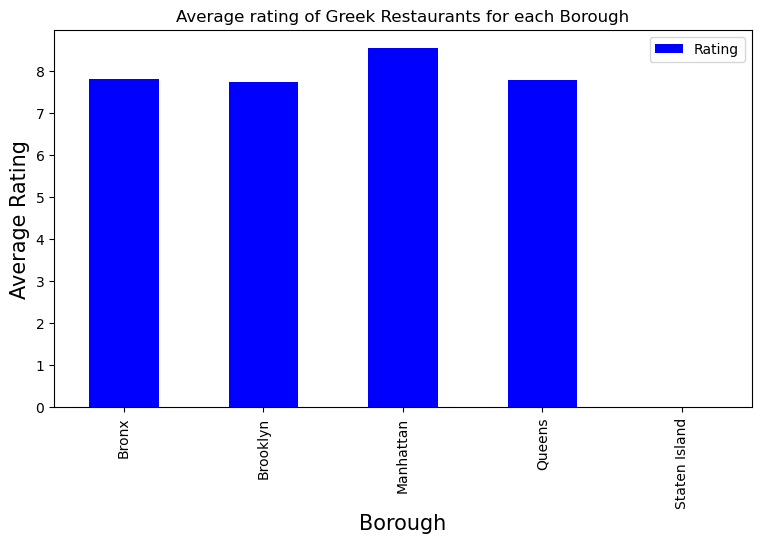

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Greek Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
greek_rest_details_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color="blue")
plt.legend()
plt.show()

In [28]:
neighborhood_stats=neighborhood_stats[neighborhood_stats['Average Rating']>=7.5]
neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.340000
2,Auburndale,7.725000
3,Bay Ridge,7.533333
4,Bayside,8.450000
5,Beechhurst,8.300000
7,Carroll Gardens,8.900000
8,Chinatown,9.100000
10,Douglaston,8.400000
12,East Village,9.100000
13,Fieldston,7.800000


In [33]:
neighborhood_stats=pd.merge(neighborhood_stats,ny_df1, on='Neighborhood')
neighborhood_stats=neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.340000
1,Queens,Auburndale,40.761730,-73.791762,7.725000
2,Brooklyn,Bay Ridge,40.625801,-74.030621,7.533333
3,Queens,Bayside,40.766041,-73.774274,8.450000
4,Queens,Beechhurst,40.792781,-73.804365,8.300000
5,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.900000
6,Manhattan,Chinatown,40.715618,-73.994279,9.100000
7,Queens,Douglaston,40.766846,-73.742498,8.400000
8,Manhattan,East Village,40.727847,-73.982226,9.100000
9,Bronx,Fieldston,40.895437,-73.905643,7.800000


In [35]:
# create map and display it
ny_city_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [37]:
neighborhood_stats['Label']=neighborhood_stats['Neighborhood']+', '+neighborhood_stats['Borough']+'('+neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

<h3>Summary<h3><br>
    <h4>
The Foursquare data indicated that although the Borough of Queens has the most Greek Restaurants of any neighbourhood.
The average ratings for each borough was highest in Manhattan (8.5), slightly lower for other boroughs (around 7.7) and nil ratings for Staten Island restaurants.<br>
The top-rated restaurant was Loukoumi Taverna in Steinway (Queens), closely followed by  Kiki’s in Chinatown (Manhattan). Maximum tips were found at Taverna Kyclades also in Steinway.
The overall ratings for the top 10 neighbourhoods indicate a concentration in Manhattan (6 out of 10). In contrast, Queens which has the most restaurants (34) with the highest rated restaurants in Steinway, comes in third behind the Bronx. Brooklyn follows with slightly lower ratings and the Bronx following. As mentioned there is no data for Staten Island at the time of review.<br>

In regards to concentration of establishments, Queens has the highest with the Bronx, the lowest. It is noted that the Bronx also has the second highest ratings for the boroughs with significantly less restaurants (4) than Queens (34) or Manhattan (20). Similarly, Brooklyn has 15 restaurants, with slightly lower overall ratings to Queens and Manhattan.
<h5>Recommendations:<h5><br>
<h4>Look closely at current restaurants in the Bronx and Brooklyn and how they operate. Go to the top rated  in each borough and understand the style, pricing and clientele to determine if the business model for expansion will suit New Yorkers.
Although this data does not show the complete picture, these two boroughs may have more opportunities than Queens and Manhattan. This may be due to less concentration of Greek restaurants, and more affordable operating costs.<h4>
